# Оценивание


- 3 - просто доделан класс U-Net и обучен. Можно сделать его чисто на своих свертках / либо взять готовый бекбон из torchvision.models по типу ResNet34 и достать из него признаки для skip connections
- 4 - обучен U-Net и проведен перебор простых гиперпараметров в конфиге (lr, batch size и тд) с графиками после тренировки. Перебор хватит делать по 3-5 значениям для 2-3 параметров. После полезно написать мысли, почему получились такие результаты
- 5 - обучен U-Net , проведен перебор гиперпаметров выше и проверена какая-либо идея по модификации U-Net (сделать глубже, добавить нормализацию слоев, поменять бекбон на другой, и тд). Также сделать 1-2 графика с результатами. После полезно написать мысли, почему получились такие результаты

# U-Net

In [1]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.metrics import jaccard_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms.v2 as transforms

from sklearn.model_selection import ParameterGrid

In [2]:
@dataclass
class Config:
    image_size = (128, 128)
    batch_size = 32
    epochs = 15
    learning_rate = 0.0001
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_split = 0.8

config = Config()

In [3]:
class PetDataset(Dataset):
    def __init__(self, root, split='trainval', transform=None):
        self.root = root
        self.transform = transform
        self.dataset = torchvision.datasets.OxfordIIITPet(root=root, split=split, target_types='segmentation', download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]

        mask = np.array(mask)
        mask = (mask > 1).astype(np.uint8)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)

        mask = mask.resize((128, 128))
        mask = F.pil_to_tensor(mask).float()

        return image, mask

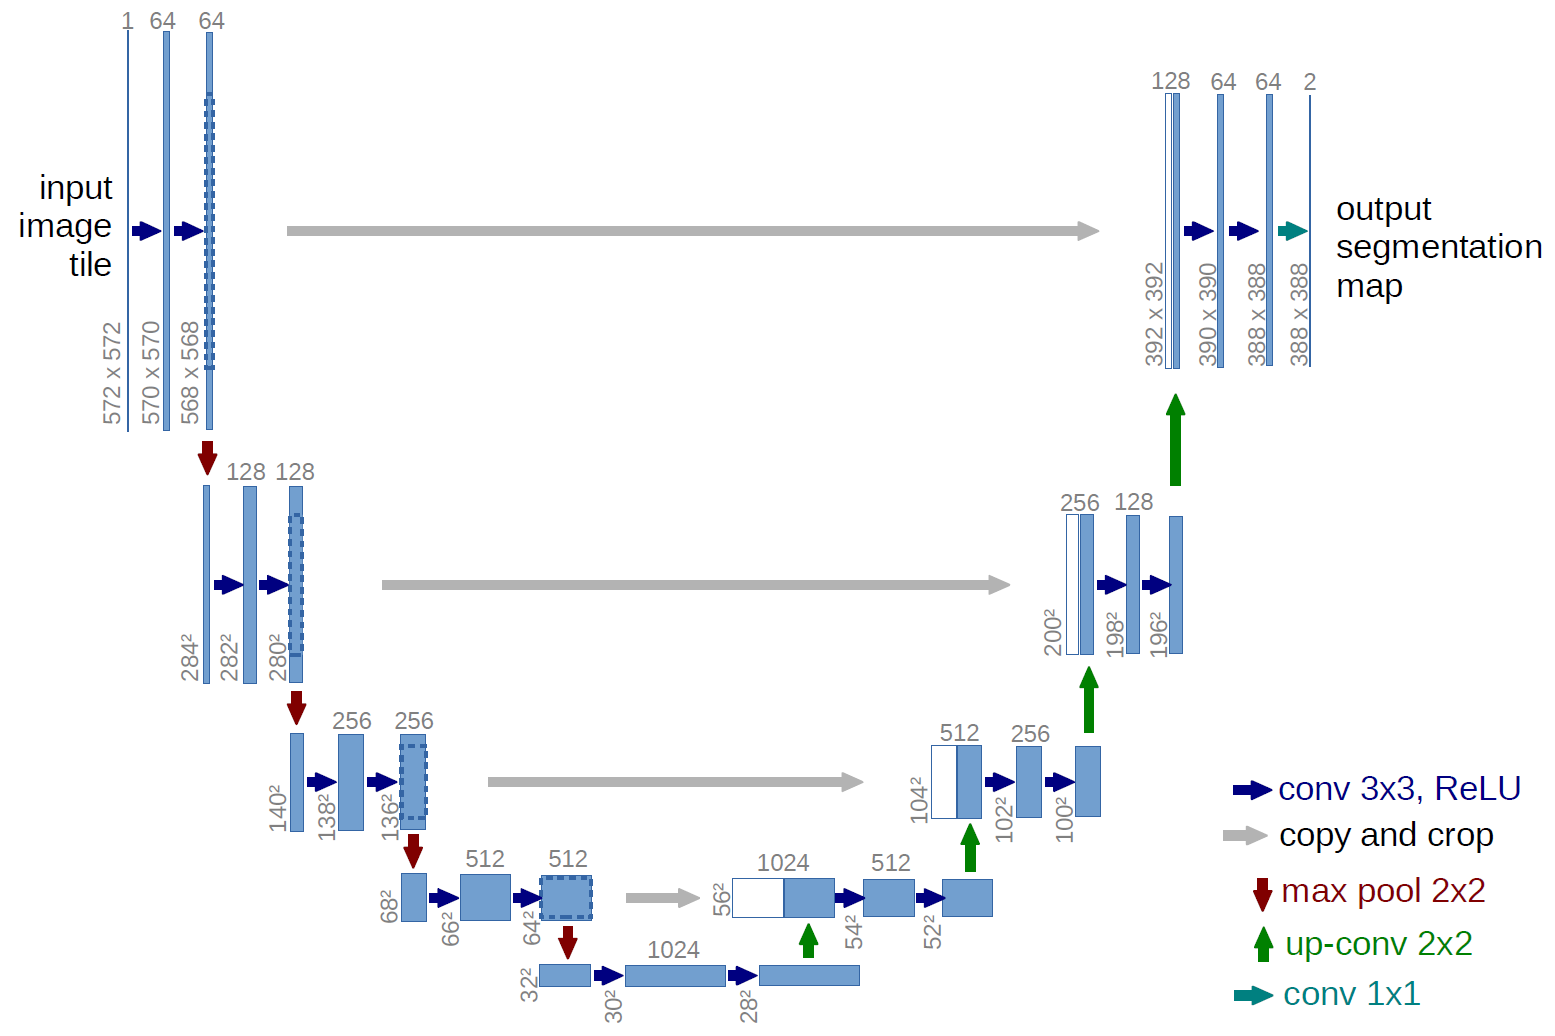

In [4]:
class EncBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncBlock, self).__init__()

        self.encblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encblock(x)

# decoder
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.enc0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding = 0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.enc = EncBlock(in_channels, out_channels)

    def forward(self, x, e):
        x = self.enc0(x) #up-conv
        x = torch.cat([x, e], 1)
        x = self.enc(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # тут слои обозначить для encoder, bottleneck и decoder
        # encoder
        self.enc1 = EncBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = EncBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = EncBlock(128,256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = EncBlock(256,512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # bottleneck
        self.bottleneck = EncBlock(512, 1024)
        # decoder + MaxUnpool2d to reverse the effect of MaxPool2d (needs indices)
        self.dec1 = Decoder(1024, 512)
        self.dec2 = Decoder(512, 256)
        self.dec3 = Decoder(256, 128)
        self.dec4 = Decoder(128, 64)
        #  end
        self.convend = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e1 = self.enc1(x) #skipconn
        p1 = self.pool1(e1)
        e2 = self.enc2(p1) #skipconn
        p2 = self.pool2(e2)
        e3 = self.enc3(p2) #skipconn
        p3 = self.pool3(e3)
        e4 = self.enc4(p3) #skipconn
        p4 = self.pool4(e4)

        # bottleneck
        b = self.bottleneck(p4)

        # decoder
        d1 = self.dec1(b, e4)
        d2 = self.dec2(d1, e3)
        d3 = self.dec3(d2, e2)
        d4 = self.dec4(d3, e1)
        x = self.convend(d4)

        return x

In [5]:
class Trainer:
    def __init__(self, config):
        self.config = config

        self.transform = transforms.Compose([
            transforms.Resize(config.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.model = UNet().to(config.device)
        # какой лосс удобный возьмем для бинарной сегментации?
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(config.device))
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)

        self.setup_dataloader()

        # Сравнение моделей
        self.train_losses = []
        self.val_losses = []
        self.val_ious = []
        self.val_f1s = []

    def setup_dataloader(self):
        dataset = PetDataset(root="./data", split='trainval', transform=self.transform)
        train_size = int(self.config.train_split * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        self.test_dataset = PetDataset(root="./data", split='test', transform=self.transform)

        self.train_dataloader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        self.val_dataloader = DataLoader(val_dataset, batch_size=self.config.batch_size, shuffle=False)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.config.batch_size, shuffle=False)

    def run(self):
        for epoch in range(self.config.epochs):
            train_loss = self.train()
            val_loss, val_iou, val_f1 = self.validate()

            # Сохранение метрик
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_ious.append(val_iou)
            self.val_f1s.append(val_f1)

            print(f"Epoch {epoch+1} / {self.config.epochs}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val IoU: {val_iou:.4f}, "
                  f"Val F1-score: {val_f1:.4f}")

        print('Testing...')
        test_loss, test_iou, test_f1 = self.test()

        print(f"Test Loss: {test_loss:.4f}, "
              f"Test IoU: {test_iou:.4f}, "
              f"Test F1-score: {test_f1:.4f}")

    def train(self):
        self.model.train()
        epoch_loss = 0

        for images, masks in tqdm(self.train_dataloader):
            images = images.to(self.config.device)
            masks = masks.to(self.config.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            loss = self.criterion(outputs, masks)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(self.train_dataloader)

    def validate(self):
        self.model.eval()
        val_loss = 0
        iou_scores, f1_scores = [], []

        with torch.no_grad():
            for images, masks in tqdm(self.val_dataloader):
                images = images.to(self.config.device)
                masks = masks.to(self.config.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                val_loss += loss.item()

                pred_masks = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(np.uint8)
                masks = masks.squeeze(1).cpu().numpy().astype(np.uint8)

                for i in range(len(pred_masks)):
                    iou_scores.append(jaccard_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))
                    f1_scores.append(f1_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))

        return val_loss / len(self.val_dataloader), np.mean(iou_scores), np.mean(f1_scores)

    def test(self):
        self.model.eval()
        test_loss = 0
        iou_scores, f1_scores = [], []

        with torch.no_grad():
            for images, masks in tqdm(self.test_dataloader):
                images = images.to(self.config.device)
                masks = masks.to(self.config.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                test_loss += loss.item()

                pred_masks = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(np.uint8)
                masks = masks.squeeze(1).cpu().numpy().astype(np.uint8)

                for i in range(len(pred_masks)):
                    iou_scores.append(jaccard_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))
                    f1_scores.append(f1_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))

        return test_loss / len(self.test_dataloader), np.mean(iou_scores), np.mean(f1_scores)

    def inference_and_plot_samples(self, n_samples=3):
        self.model.eval()

        with torch.no_grad():
            fig, axes = plt.subplots(n_samples, 3, figsize=(10, 3 * n_samples))

            for i in range(n_samples):
                img, mask = self.test_dataset[i]
                img_tensor = img.unsqueeze(0).to(self.config.device)

                output = self.model(img_tensor)
                output = torch.sigmoid(output).squeeze().cpu().numpy()
                output = (output >= 0.5).astype('float')

                axes[i, 0].imshow(img.permute(1, 2, 0).cpu())
                axes[i, 0].set_title("Image")
                axes[i, 1].imshow(mask.squeeze().cpu(), cmap="gray")
                axes[i, 1].set_title("Ground Truth")
                axes[i, 2].imshow(output, cmap="gray")
                axes[i, 2].set_title("Predicted Mask")

            plt.show()


In [7]:
trainer = Trainer(config)

In [9]:
trainer.run()

100%|██████████| 23/23 [00:11<00:00,  1.92it/s]


Epoch 1 / 15, Train Loss: 1.3334, Val Loss: 1.5992, Val IoU: 0.7039, Val F1-score: 0.8184


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Epoch 2 / 15, Train Loss: 1.1762, Val Loss: 1.0895, Val IoU: 0.8367, Val F1-score: 0.9053


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Epoch 3 / 15, Train Loss: 1.1230, Val Loss: 1.0902, Val IoU: 0.8378, Val F1-score: 0.9062


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Epoch 4 / 15, Train Loss: 1.0899, Val Loss: 1.1280, Val IoU: 0.8507, Val F1-score: 0.9141


100%|██████████| 23/23 [00:11<00:00,  2.00it/s]


Epoch 5 / 15, Train Loss: 1.0572, Val Loss: 1.0683, Val IoU: 0.8586, Val F1-score: 0.9192


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Epoch 6 / 15, Train Loss: 1.0344, Val Loss: 1.0752, Val IoU: 0.8559, Val F1-score: 0.9170


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 7 / 15, Train Loss: 1.0084, Val Loss: 0.9645, Val IoU: 0.8655, Val F1-score: 0.9231


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 8 / 15, Train Loss: 0.9844, Val Loss: 1.0411, Val IoU: 0.8666, Val F1-score: 0.9238


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 9 / 15, Train Loss: 0.9669, Val Loss: 1.0271, Val IoU: 0.8716, Val F1-score: 0.9271


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 10 / 15, Train Loss: 0.9476, Val Loss: 1.0755, Val IoU: 0.8544, Val F1-score: 0.9157


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 11 / 15, Train Loss: 0.9272, Val Loss: 1.0109, Val IoU: 0.8746, Val F1-score: 0.9289


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 12 / 15, Train Loss: 0.9180, Val Loss: 0.9586, Val IoU: 0.8777, Val F1-score: 0.9306


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 13 / 15, Train Loss: 0.8952, Val Loss: 1.0013, Val IoU: 0.8781, Val F1-score: 0.9311


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 14 / 15, Train Loss: 0.8773, Val Loss: 0.9687, Val IoU: 0.8776, Val F1-score: 0.9307


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 15 / 15, Train Loss: 0.8601, Val Loss: 0.9536, Val IoU: 0.8848, Val F1-score: 0.9351
Testing...


100%|██████████| 115/115 [00:55<00:00,  2.07it/s]

Test Loss: 0.9595, Test IoU: 0.8833, Test F1-score: 0.9337


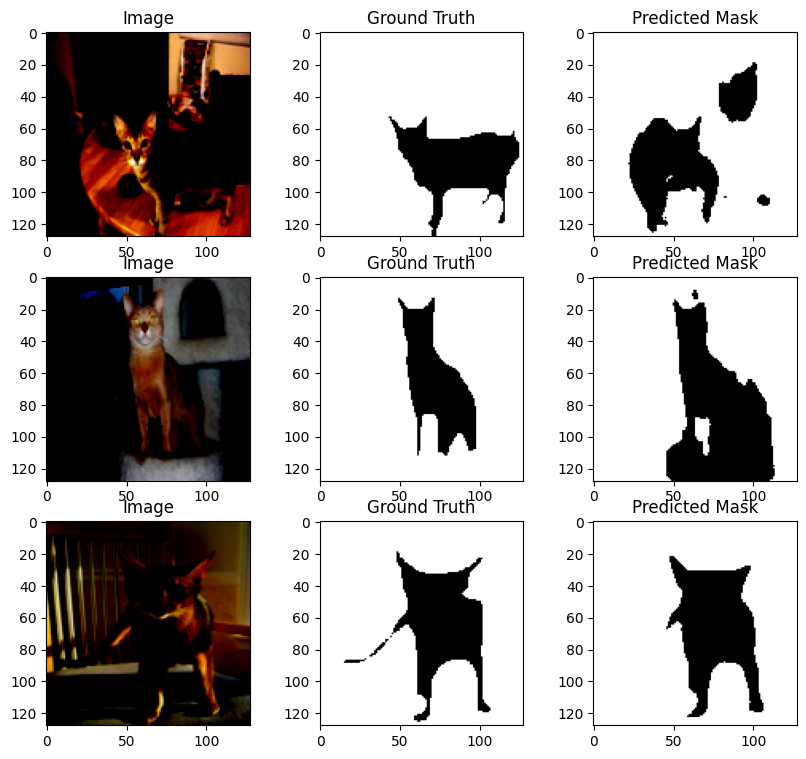

In [11]:
trainer.inference_and_plot_samples(n_samples=3)

In [12]:
train_losses = trainer.train_losses
val_losses = trainer.val_losses
val_ious = trainer.val_ious
val_f1s = trainer.val_f1s

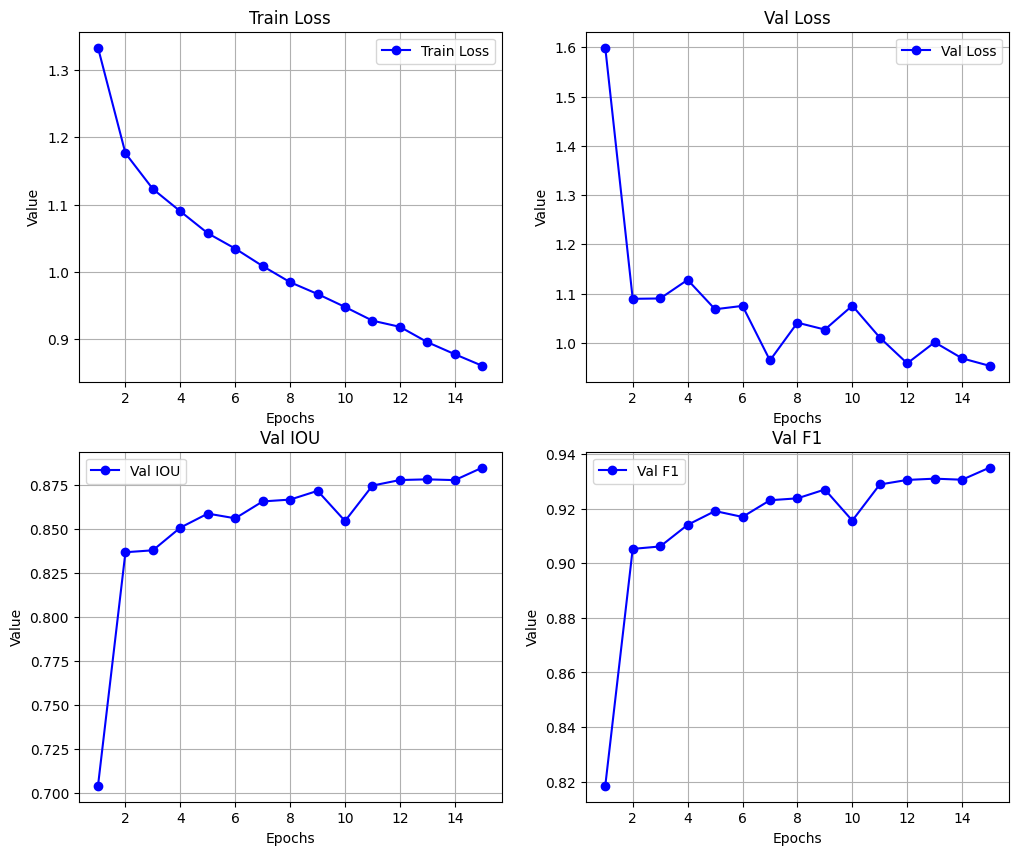

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', marker='o')
axs[0, 0].set_title('Train Loss')

axs[0, 1].plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='blue', marker='o')
axs[0, 1].set_title('Val Loss')

axs[1, 0].plot(range(1, len(val_ious) + 1), val_ious, label='Val IOU', color='blue', marker='o')
axs[1, 0].set_title('Val IOU')

axs[1, 1].plot(range(1, len(val_f1s) + 1), val_f1s, label='Val F1', color='blue', marker='o')
axs[1, 1].set_title('Val F1')


for i in range(2):
  for j in range(2):
    axs[i, j].set_xlabel('Epochs')
    axs[i, j].set_ylabel('Value')
    axs[i, j].legend()
    axs[i, j].grid()


# Перебор гиперпараметров

In [ ]:
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [8, 16, 32]
}
grid_unet = ParameterGrid(param_grid)

In [ ]:
def train_and_evaluate_params(params):
    print(f"Training with params: {params}")

    class Config_params:
        def __init__(self):
            self.image_size = (128, 128)
            self.batch_size = params['batch_size']
            self.epochs = 10
            self.learning_rate = params['learning_rate']
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.train_split = 0.8

    config_params = Config_params()

    model = Trainer(config_params)
    model.run()

    return {
        'train_losses': model.train_losses,
        'val_losses': model.val_losses,
        'val_ious': model.val_ious,
        'val_f1s': model.val_f1s
    }

In [ ]:
def plot_params(params, metrics):
    fig, axs = plt.subplots(1, 4, figsize=(30, 5))
    fig.suptitle(f"Params: LR={params['learning_rate']}, BS={params['batch_size']}", fontsize=12)

    axs[0].plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label='Train Loss', color='blue', marker='o')
    axs[0].set_title('Train Loss')

    axs[1].plot(range(1, len(metrics['val_losses']) + 1), metrics['val_losses'], label='Val Loss', color='blue', marker='o')
    axs[1].set_title('Val Loss')

    axs[2].plot(range(1, len(metrics['val_ious']) + 1), metrics['val_ious'], label='Val IOU', color='blue', marker='o')
    axs[2].set_title('Val IOU')

    axs[3].plot(range(1, len(metrics['val_f1s']) + 1), metrics['val_f1s'], label='Val F1', color='blue', marker='o')
    axs[3].set_title('Val F1')

    for i in range(4):
      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel('Value')
      axs[i].legend()
      axs[i].grid()


Training with params: {'batch_size': 8, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 92/92 [00:12<00:00,  7.54it/s]


Epoch 1 / 10, Train Loss: 1.2860, Val Loss: 1.0971, Val IoU: 0.7593, Val F1-score: 0.8575


100%|██████████| 92/92 [00:12<00:00,  7.58it/s]


Epoch 2 / 10, Train Loss: 0.9953, Val Loss: 0.8284, Val IoU: 0.7902, Val F1-score: 0.8758


100%|██████████| 92/92 [00:12<00:00,  7.52it/s]


Epoch 3 / 10, Train Loss: 0.7961, Val Loss: 0.7639, Val IoU: 0.8074, Val F1-score: 0.8878


100%|██████████| 92/92 [00:12<00:00,  7.54it/s]


Epoch 4 / 10, Train Loss: 0.6635, Val Loss: 0.5935, Val IoU: 0.7900, Val F1-score: 0.8743


100%|██████████| 92/92 [00:12<00:00,  7.37it/s]


Epoch 5 / 10, Train Loss: 0.5739, Val Loss: 0.5154, Val IoU: 0.8007, Val F1-score: 0.8826


100%|██████████| 92/92 [00:12<00:00,  7.57it/s]


Epoch 6 / 10, Train Loss: 0.5077, Val Loss: 0.4830, Val IoU: 0.8420, Val F1-score: 0.9079


100%|██████████| 92/92 [00:12<00:00,  7.63it/s]


Epoch 7 / 10, Train Loss: 0.4576, Val Loss: 0.4354, Val IoU: 0.8313, Val F1-score: 0.9018


100%|██████████| 92/92 [00:12<00:00,  7.51it/s]


Epoch 8 / 10, Train Loss: 0.4276, Val Loss: 0.4268, Val IoU: 0.8418, Val F1-score: 0.9086


100%|██████████| 92/92 [00:12<00:00,  7.55it/s]


Epoch 9 / 10, Train Loss: 0.3974, Val Loss: 0.4059, Val IoU: 0.8420, Val F1-score: 0.9090


100%|██████████| 92/92 [00:12<00:00,  7.53it/s]


Epoch 10 / 10, Train Loss: 0.3779, Val Loss: 0.3794, Val IoU: 0.8692, Val F1-score: 0.9263
Testing...


100%|██████████| 459/459 [01:01<00:00,  7.43it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 0.3821, Test IoU: 0.8650, Test F1-score: 0.9229
Training with params: {'batch_size': 8, 'learning_rate': 0.0001}


100%|██████████| 92/92 [00:12<00:00,  7.66it/s]


Epoch 1 / 10, Train Loss: 1.2641, Val Loss: 1.3253, Val IoU: 0.7527, Val F1-score: 0.8520


100%|██████████| 92/92 [00:12<00:00,  7.59it/s]


Epoch 2 / 10, Train Loss: 1.1166, Val Loss: 1.0092, Val IoU: 0.8503, Val F1-score: 0.9142


100%|██████████| 92/92 [00:12<00:00,  7.57it/s]


Epoch 3 / 10, Train Loss: 1.0552, Val Loss: 0.9933, Val IoU: 0.8655, Val F1-score: 0.9243


100%|██████████| 92/92 [00:12<00:00,  7.60it/s]


Epoch 4 / 10, Train Loss: 0.9923, Val Loss: 0.9307, Val IoU: 0.8765, Val F1-score: 0.9304


100%|██████████| 92/92 [00:12<00:00,  7.66it/s]


Epoch 5 / 10, Train Loss: 0.9496, Val Loss: 0.9032, Val IoU: 0.8825, Val F1-score: 0.9343


100%|██████████| 92/92 [00:12<00:00,  7.62it/s]


Epoch 6 / 10, Train Loss: 0.9039, Val Loss: 0.9279, Val IoU: 0.8676, Val F1-score: 0.9251


100%|██████████| 92/92 [00:12<00:00,  7.56it/s]


Epoch 7 / 10, Train Loss: 0.8616, Val Loss: 0.8729, Val IoU: 0.8807, Val F1-score: 0.9332


100%|██████████| 92/92 [00:12<00:00,  7.62it/s]


Epoch 8 / 10, Train Loss: 0.8221, Val Loss: 0.8207, Val IoU: 0.8871, Val F1-score: 0.9367


100%|██████████| 92/92 [00:12<00:00,  7.59it/s]


Epoch 9 / 10, Train Loss: 0.7879, Val Loss: 0.7917, Val IoU: 0.8915, Val F1-score: 0.9397


100%|██████████| 92/92 [00:12<00:00,  7.60it/s]


Epoch 10 / 10, Train Loss: 0.7555, Val Loss: 0.7735, Val IoU: 0.8814, Val F1-score: 0.9335
Testing...


100%|██████████| 459/459 [01:01<00:00,  7.44it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 0.7770, Test IoU: 0.8813, Test F1-score: 0.9324
Training with params: {'batch_size': 8, 'learning_rate': 1e-05}


100%|██████████| 92/92 [00:12<00:00,  7.49it/s]


Epoch 1 / 10, Train Loss: 1.4107, Val Loss: 1.2775, Val IoU: 0.7624, Val F1-score: 0.8590


100%|██████████| 92/92 [00:12<00:00,  7.49it/s]


Epoch 2 / 10, Train Loss: 1.2201, Val Loss: 1.1499, Val IoU: 0.8124, Val F1-score: 0.8899


100%|██████████| 92/92 [00:12<00:00,  7.56it/s]


Epoch 3 / 10, Train Loss: 1.1717, Val Loss: 1.1420, Val IoU: 0.8221, Val F1-score: 0.8964


100%|██████████| 92/92 [00:12<00:00,  7.59it/s]


Epoch 4 / 10, Train Loss: 1.1385, Val Loss: 1.1430, Val IoU: 0.8226, Val F1-score: 0.8965


100%|██████████| 92/92 [00:12<00:00,  7.49it/s]


Epoch 5 / 10, Train Loss: 1.1053, Val Loss: 1.1454, Val IoU: 0.8311, Val F1-score: 0.9022


100%|██████████| 92/92 [00:12<00:00,  7.57it/s]


Epoch 6 / 10, Train Loss: 1.0770, Val Loss: 1.1644, Val IoU: 0.8242, Val F1-score: 0.8979


100%|██████████| 92/92 [00:12<00:00,  7.18it/s]


Epoch 7 / 10, Train Loss: 1.0547, Val Loss: 1.0759, Val IoU: 0.8360, Val F1-score: 0.9044


100%|██████████| 92/92 [00:12<00:00,  7.60it/s]


Epoch 8 / 10, Train Loss: 1.0323, Val Loss: 1.1543, Val IoU: 0.8330, Val F1-score: 0.9035


100%|██████████| 92/92 [00:12<00:00,  7.59it/s]


Epoch 9 / 10, Train Loss: 1.0154, Val Loss: 1.1796, Val IoU: 0.8221, Val F1-score: 0.8970


100%|██████████| 92/92 [00:12<00:00,  7.60it/s]


Epoch 10 / 10, Train Loss: 1.0039, Val Loss: 1.0806, Val IoU: 0.8433, Val F1-score: 0.9094
Testing...


100%|██████████| 459/459 [01:01<00:00,  7.48it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 1.0752, Test IoU: 0.8467, Test F1-score: 0.9114
Training with params: {'batch_size': 16, 'learning_rate': 0.001}


100%|██████████| 46/46 [00:11<00:00,  3.99it/s]


Epoch 1 / 10, Train Loss: 1.3611, Val Loss: 1.1333, Val IoU: 0.7576, Val F1-score: 0.8551


100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


Epoch 2 / 10, Train Loss: 1.0966, Val Loss: 0.9818, Val IoU: 0.7994, Val F1-score: 0.8821


100%|██████████| 46/46 [00:11<00:00,  3.99it/s]


Epoch 3 / 10, Train Loss: 0.9339, Val Loss: 1.0096, Val IoU: 0.7907, Val F1-score: 0.8776


100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


Epoch 4 / 10, Train Loss: 0.8037, Val Loss: 0.7173, Val IoU: 0.8323, Val F1-score: 0.9033


100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


Epoch 5 / 10, Train Loss: 0.7173, Val Loss: 0.7685, Val IoU: 0.8322, Val F1-score: 0.9025


100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


Epoch 6 / 10, Train Loss: 0.6311, Val Loss: 0.6355, Val IoU: 0.8452, Val F1-score: 0.9109


100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


Epoch 7 / 10, Train Loss: 0.5726, Val Loss: 0.7259, Val IoU: 0.8376, Val F1-score: 0.9058


100%|██████████| 46/46 [00:11<00:00,  4.08it/s]


Epoch 8 / 10, Train Loss: 0.5367, Val Loss: 0.5492, Val IoU: 0.8661, Val F1-score: 0.9243


100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


Epoch 9 / 10, Train Loss: 0.4873, Val Loss: 0.5770, Val IoU: 0.8648, Val F1-score: 0.9232


100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


Epoch 10 / 10, Train Loss: 0.4506, Val Loss: 0.4702, Val IoU: 0.8424, Val F1-score: 0.9088
Testing...


100%|██████████| 230/230 [00:59<00:00,  3.84it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 0.4796, Test IoU: 0.8342, Test F1-score: 0.9025
Training with params: {'batch_size': 16, 'learning_rate': 0.0001}


100%|██████████| 46/46 [00:11<00:00,  3.97it/s]


Epoch 1 / 10, Train Loss: 1.2999, Val Loss: 1.1840, Val IoU: 0.8022, Val F1-score: 0.8847


100%|██████████| 46/46 [00:11<00:00,  3.91it/s]


Epoch 2 / 10, Train Loss: 1.1456, Val Loss: 1.1111, Val IoU: 0.8322, Val F1-score: 0.9035


100%|██████████| 46/46 [00:11<00:00,  3.98it/s]


Epoch 3 / 10, Train Loss: 1.0932, Val Loss: 1.1221, Val IoU: 0.8389, Val F1-score: 0.9078


100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Epoch 4 / 10, Train Loss: 1.0527, Val Loss: 1.0977, Val IoU: 0.8451, Val F1-score: 0.9115


100%|██████████| 46/46 [00:11<00:00,  3.97it/s]


Epoch 5 / 10, Train Loss: 1.0193, Val Loss: 1.0402, Val IoU: 0.8621, Val F1-score: 0.9221


100%|██████████| 46/46 [00:11<00:00,  3.91it/s]


Epoch 6 / 10, Train Loss: 0.9852, Val Loss: 0.9487, Val IoU: 0.8569, Val F1-score: 0.9170


100%|██████████| 46/46 [00:11<00:00,  3.96it/s]


Epoch 7 / 10, Train Loss: 0.9565, Val Loss: 1.0029, Val IoU: 0.8669, Val F1-score: 0.9243


100%|██████████| 46/46 [00:11<00:00,  3.93it/s]


Epoch 8 / 10, Train Loss: 0.9301, Val Loss: 0.9630, Val IoU: 0.8732, Val F1-score: 0.9282


100%|██████████| 46/46 [00:11<00:00,  3.99it/s]


Epoch 9 / 10, Train Loss: 0.8974, Val Loss: 0.9466, Val IoU: 0.8709, Val F1-score: 0.9269


100%|██████████| 46/46 [00:11<00:00,  3.97it/s]


Epoch 10 / 10, Train Loss: 0.8745, Val Loss: 0.9166, Val IoU: 0.8762, Val F1-score: 0.9300
Testing...


100%|██████████| 230/230 [00:59<00:00,  3.86it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 0.9282, Test IoU: 0.8796, Test F1-score: 0.9315
Training with params: {'batch_size': 16, 'learning_rate': 1e-05}


100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


Epoch 1 / 10, Train Loss: 1.4978, Val Loss: 1.1731, Val IoU: 0.7671, Val F1-score: 0.8614


100%|██████████| 46/46 [00:11<00:00,  3.99it/s]


Epoch 2 / 10, Train Loss: 1.2493, Val Loss: 1.2553, Val IoU: 0.7738, Val F1-score: 0.8669


100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


Epoch 3 / 10, Train Loss: 1.1962, Val Loss: 1.2439, Val IoU: 0.7869, Val F1-score: 0.8742


100%|██████████| 46/46 [00:11<00:00,  3.92it/s]


Epoch 4 / 10, Train Loss: 1.1576, Val Loss: 1.3539, Val IoU: 0.7578, Val F1-score: 0.8559


100%|██████████| 46/46 [00:11<00:00,  4.10it/s]


Epoch 5 / 10, Train Loss: 1.1242, Val Loss: 1.1430, Val IoU: 0.8209, Val F1-score: 0.8958


100%|██████████| 46/46 [00:11<00:00,  3.93it/s]


Epoch 6 / 10, Train Loss: 1.0945, Val Loss: 1.1438, Val IoU: 0.8228, Val F1-score: 0.8973


100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


Epoch 7 / 10, Train Loss: 1.0685, Val Loss: 1.1207, Val IoU: 0.8279, Val F1-score: 0.8998


100%|██████████| 46/46 [00:11<00:00,  3.99it/s]


Epoch 8 / 10, Train Loss: 1.0531, Val Loss: 1.1181, Val IoU: 0.8290, Val F1-score: 0.9007


100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


Epoch 9 / 10, Train Loss: 1.0348, Val Loss: 1.1636, Val IoU: 0.8237, Val F1-score: 0.8982


100%|██████████| 46/46 [00:11<00:00,  3.97it/s]


Epoch 10 / 10, Train Loss: 1.0255, Val Loss: 1.1913, Val IoU: 0.8235, Val F1-score: 0.8980
Testing...


100%|██████████| 230/230 [01:00<00:00,  3.82it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 1.1960, Test IoU: 0.8300, Test F1-score: 0.9016
Training with params: {'batch_size': 32, 'learning_rate': 0.001}


100%|██████████| 23/23 [00:10<00:00,  2.13it/s]


Epoch 1 / 10, Train Loss: 1.3516, Val Loss: 1.3117, Val IoU: 0.7466, Val F1-score: 0.8494


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 2 / 10, Train Loss: 1.1916, Val Loss: 1.0897, Val IoU: 0.7857, Val F1-score: 0.8737


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 3 / 10, Train Loss: 1.0394, Val Loss: 0.9662, Val IoU: 0.8185, Val F1-score: 0.8949


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 4 / 10, Train Loss: 0.9327, Val Loss: 1.2771, Val IoU: 0.7727, Val F1-score: 0.8639


100%|██████████| 23/23 [00:10<00:00,  2.14it/s]


Epoch 5 / 10, Train Loss: 0.8340, Val Loss: 0.8467, Val IoU: 0.8430, Val F1-score: 0.9102


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 6 / 10, Train Loss: 0.7666, Val Loss: 0.7551, Val IoU: 0.8469, Val F1-score: 0.9118


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 7 / 10, Train Loss: 0.7094, Val Loss: 0.6539, Val IoU: 0.8408, Val F1-score: 0.9075


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 8 / 10, Train Loss: 0.6520, Val Loss: 0.6752, Val IoU: 0.8630, Val F1-score: 0.9222


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 9 / 10, Train Loss: 0.6084, Val Loss: 0.6498, Val IoU: 0.8581, Val F1-score: 0.9190


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 10 / 10, Train Loss: 0.5729, Val Loss: 0.9387, Val IoU: 0.8407, Val F1-score: 0.9069
Testing...


100%|██████████| 115/115 [00:54<00:00,  2.10it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 0.9071, Test IoU: 0.8477, Test F1-score: 0.9106
Training with params: {'batch_size': 32, 'learning_rate': 0.0001}


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 1 / 10, Train Loss: 1.3250, Val Loss: 1.3627, Val IoU: 0.7724, Val F1-score: 0.8657


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 2 / 10, Train Loss: 1.1660, Val Loss: 1.3267, Val IoU: 0.7801, Val F1-score: 0.8704


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Epoch 3 / 10, Train Loss: 1.1158, Val Loss: 1.0732, Val IoU: 0.8482, Val F1-score: 0.9131


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 4 / 10, Train Loss: 1.0827, Val Loss: 1.1486, Val IoU: 0.8442, Val F1-score: 0.9105


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 5 / 10, Train Loss: 1.0504, Val Loss: 1.0521, Val IoU: 0.8551, Val F1-score: 0.9173


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 6 / 10, Train Loss: 1.0260, Val Loss: 1.0692, Val IoU: 0.8596, Val F1-score: 0.9203


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 7 / 10, Train Loss: 1.0044, Val Loss: 1.0169, Val IoU: 0.8686, Val F1-score: 0.9256


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 8 / 10, Train Loss: 0.9808, Val Loss: 1.0519, Val IoU: 0.8630, Val F1-score: 0.9218


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Epoch 9 / 10, Train Loss: 0.9715, Val Loss: 1.0217, Val IoU: 0.8747, Val F1-score: 0.9294


100%|██████████| 23/23 [00:10<00:00,  2.09it/s]


Epoch 10 / 10, Train Loss: 0.9416, Val Loss: 1.0200, Val IoU: 0.8707, Val F1-score: 0.9269
Testing...


100%|██████████| 115/115 [00:55<00:00,  2.06it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Test Loss: 1.0071, Test IoU: 0.8759, Test F1-score: 0.9290
Training with params: {'batch_size': 32, 'learning_rate': 1e-05}


100%|██████████| 23/23 [00:11<00:00,  2.06it/s]


Epoch 1 / 10, Train Loss: 1.5685, Val Loss: 1.2842, Val IoU: 0.7399, Val F1-score: 0.8449


100%|██████████| 23/23 [00:11<00:00,  2.09it/s]


Epoch 2 / 10, Train Loss: 1.2764, Val Loss: 1.2738, Val IoU: 0.7641, Val F1-score: 0.8614


100%|██████████| 23/23 [00:11<00:00,  2.07it/s]


Epoch 3 / 10, Train Loss: 1.2147, Val Loss: 1.1924, Val IoU: 0.8002, Val F1-score: 0.8839


100%|██████████| 23/23 [00:11<00:00,  2.06it/s]


Epoch 4 / 10, Train Loss: 1.1684, Val Loss: 1.1520, Val IoU: 0.8153, Val F1-score: 0.8934


100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch 5 / 10, Train Loss: 1.1301, Val Loss: 1.2516, Val IoU: 0.7980, Val F1-score: 0.8826


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Epoch 6 / 10, Train Loss: 1.0980, Val Loss: 1.1984, Val IoU: 0.8105, Val F1-score: 0.8903


100%|██████████| 23/23 [00:11<00:00,  2.07it/s]


Epoch 7 / 10, Train Loss: 1.0737, Val Loss: 1.1155, Val IoU: 0.8208, Val F1-score: 0.8960


100%|██████████| 23/23 [00:11<00:00,  2.09it/s]


Epoch 8 / 10, Train Loss: 1.0539, Val Loss: 1.2543, Val IoU: 0.7943, Val F1-score: 0.8802


100%|██████████| 23/23 [00:10<00:00,  2.09it/s]


Epoch 9 / 10, Train Loss: 1.0417, Val Loss: 1.1120, Val IoU: 0.8282, Val F1-score: 0.9009


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Epoch 10 / 10, Train Loss: 1.0281, Val Loss: 1.1525, Val IoU: 0.8248, Val F1-score: 0.8991
Testing...


100%|██████████| 115/115 [00:56<00:00,  2.05it/s]


Test Loss: 1.1516, Test IoU: 0.8248, Test F1-score: 0.8980


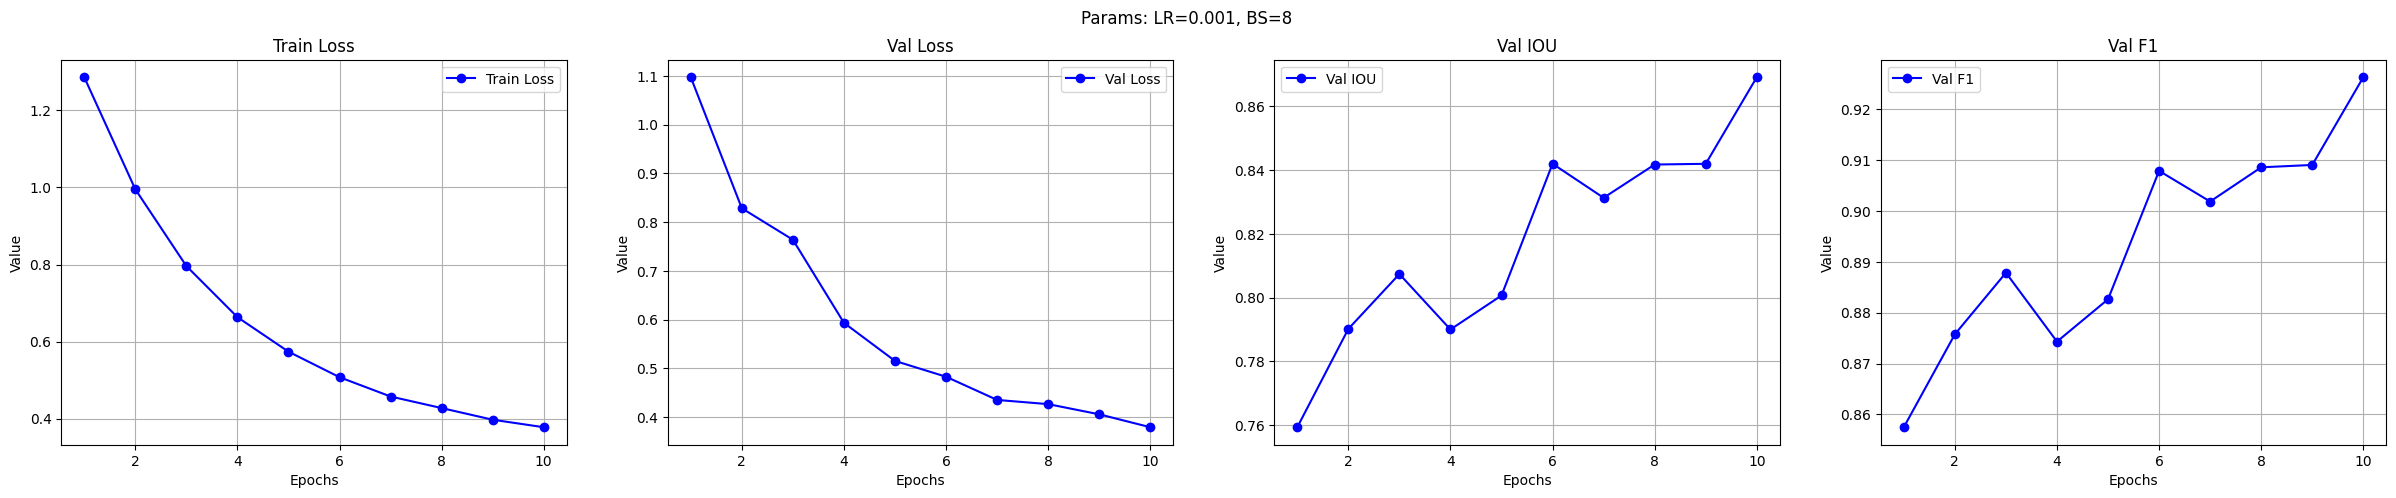

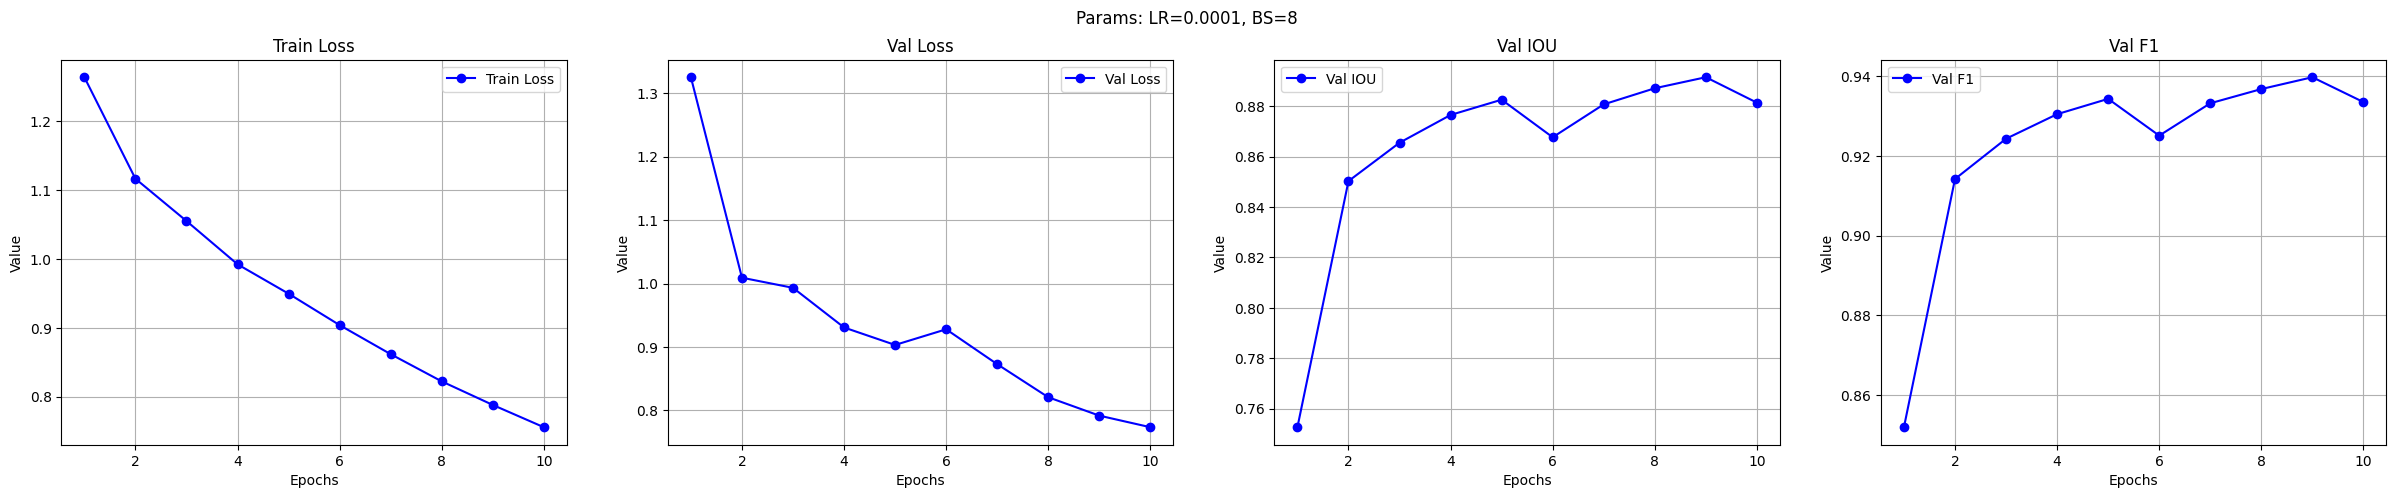

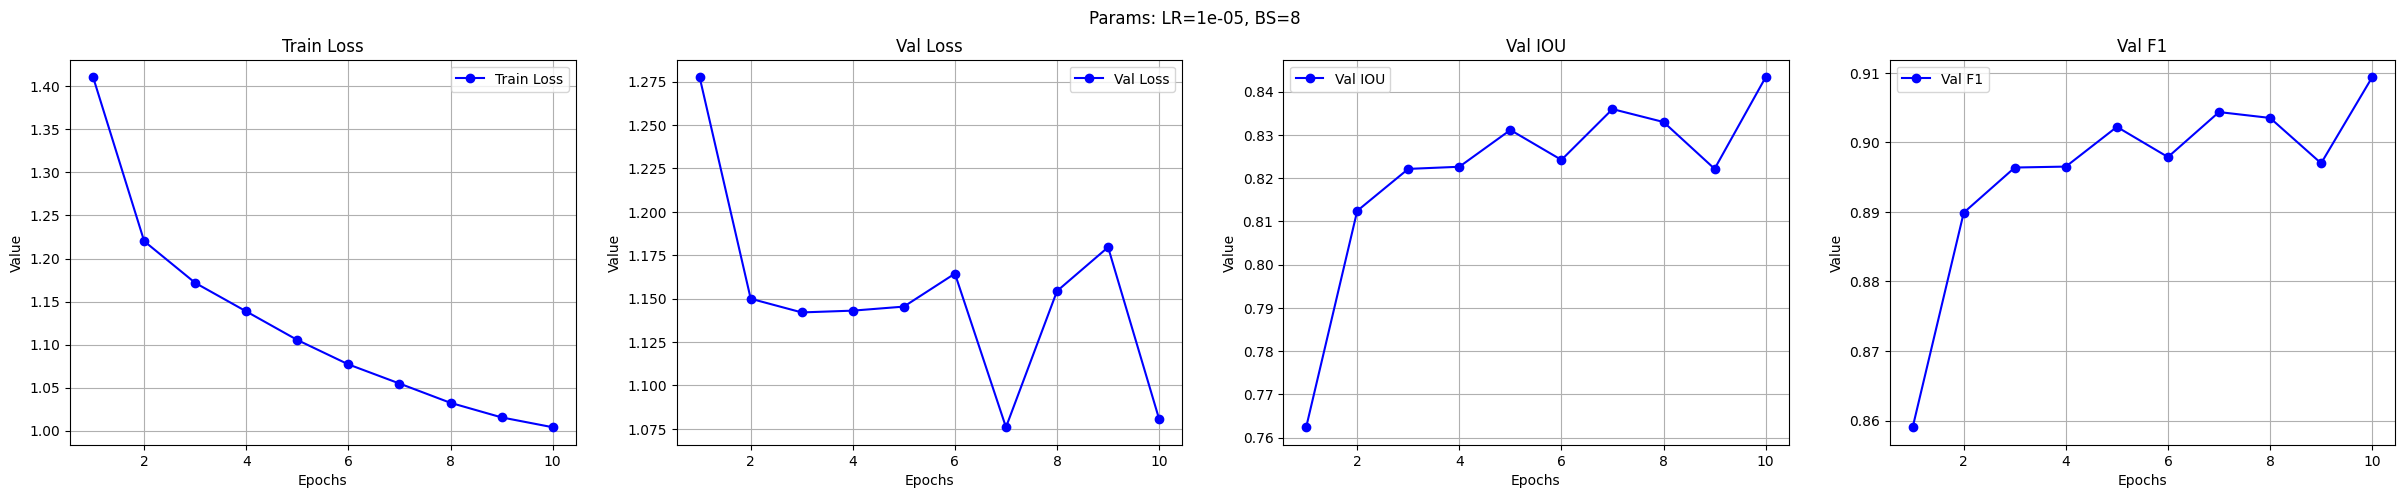

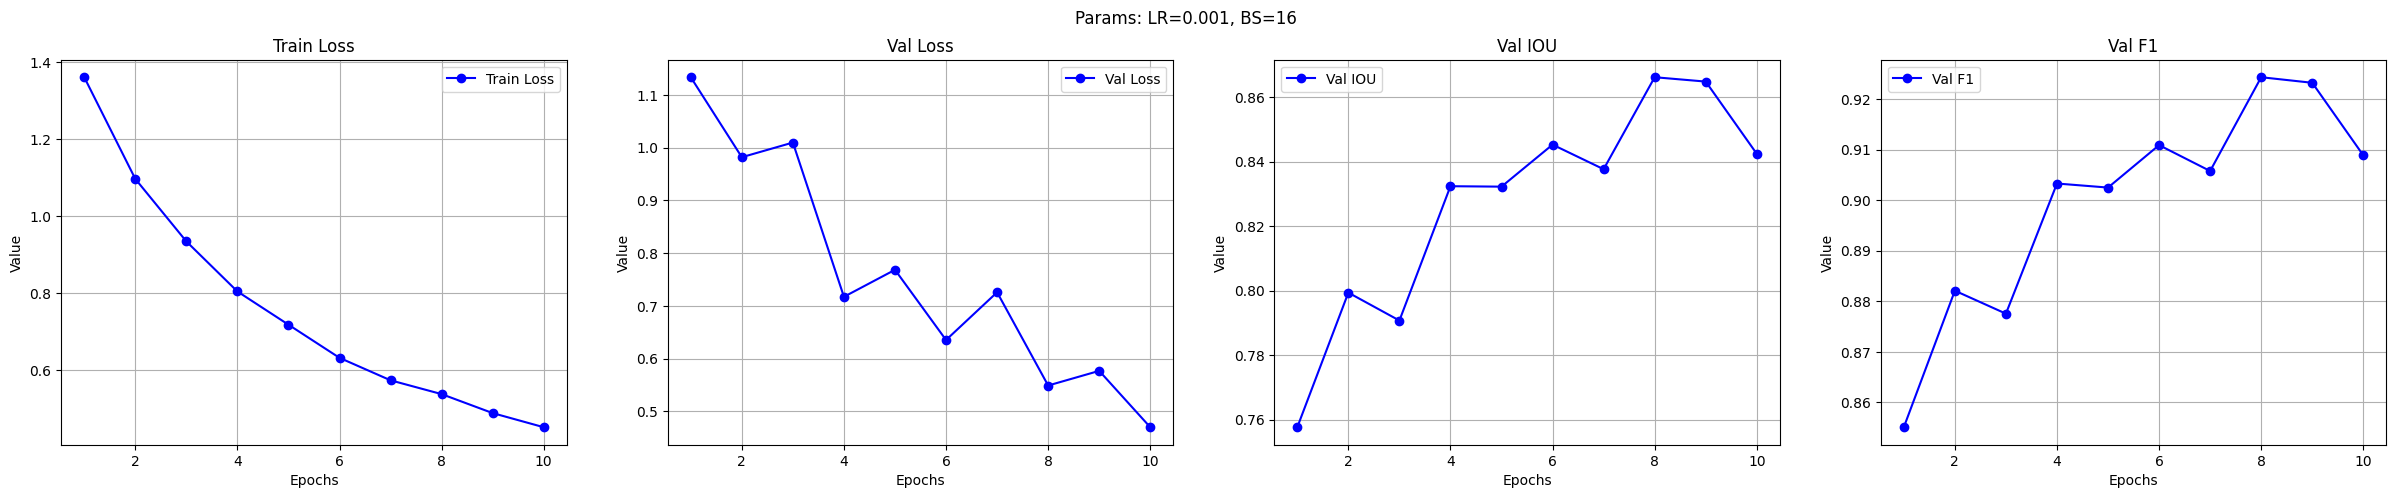

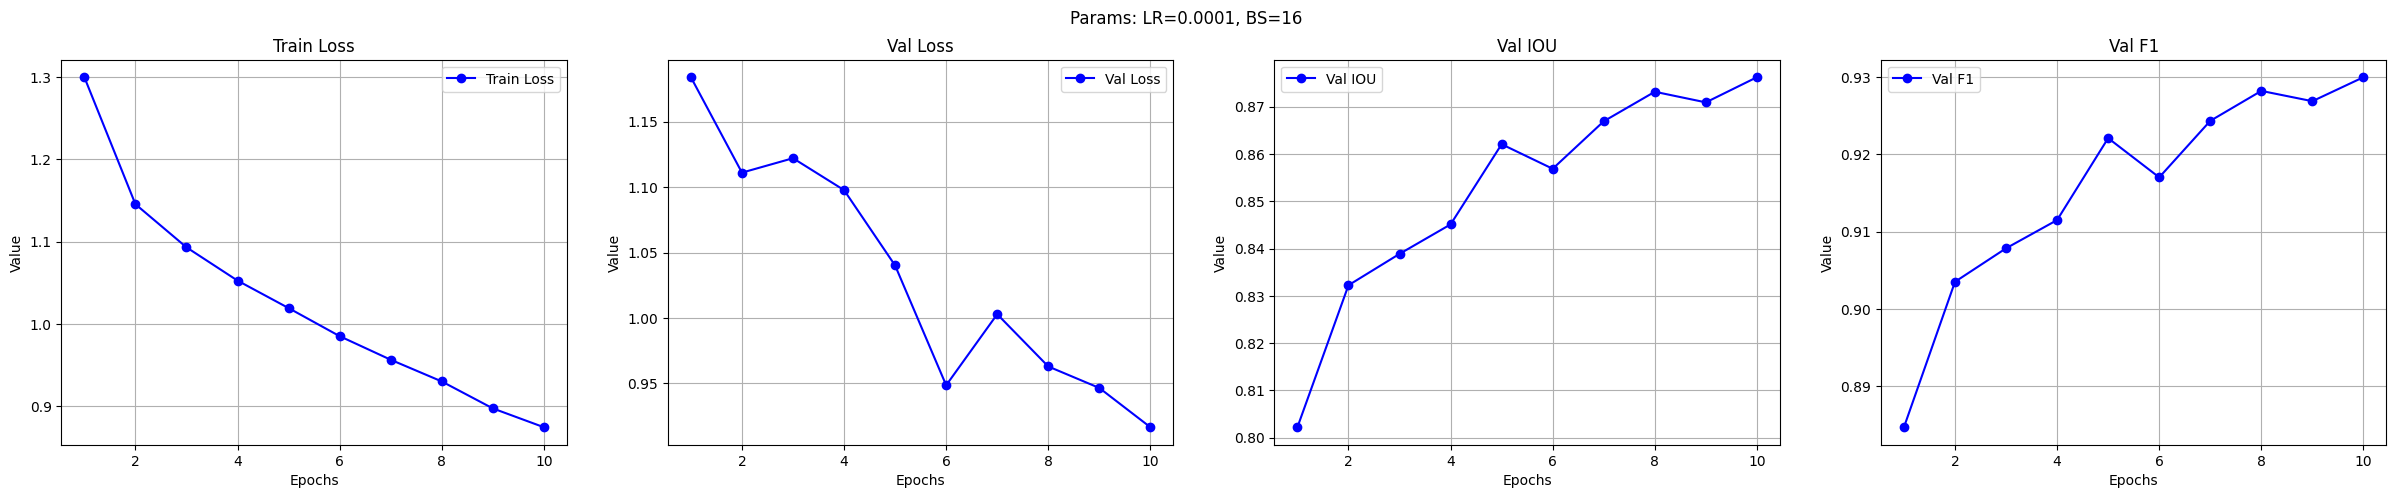

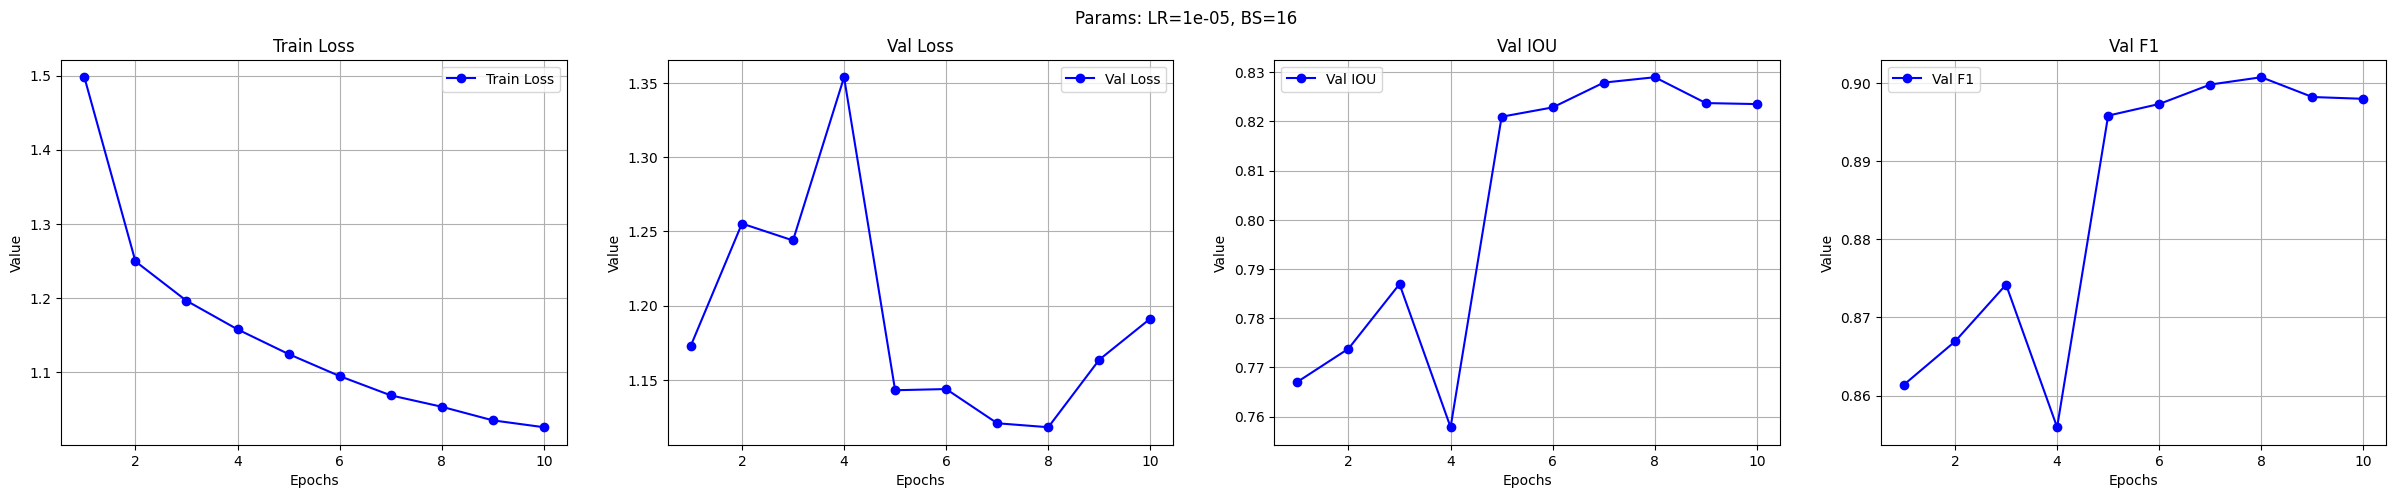

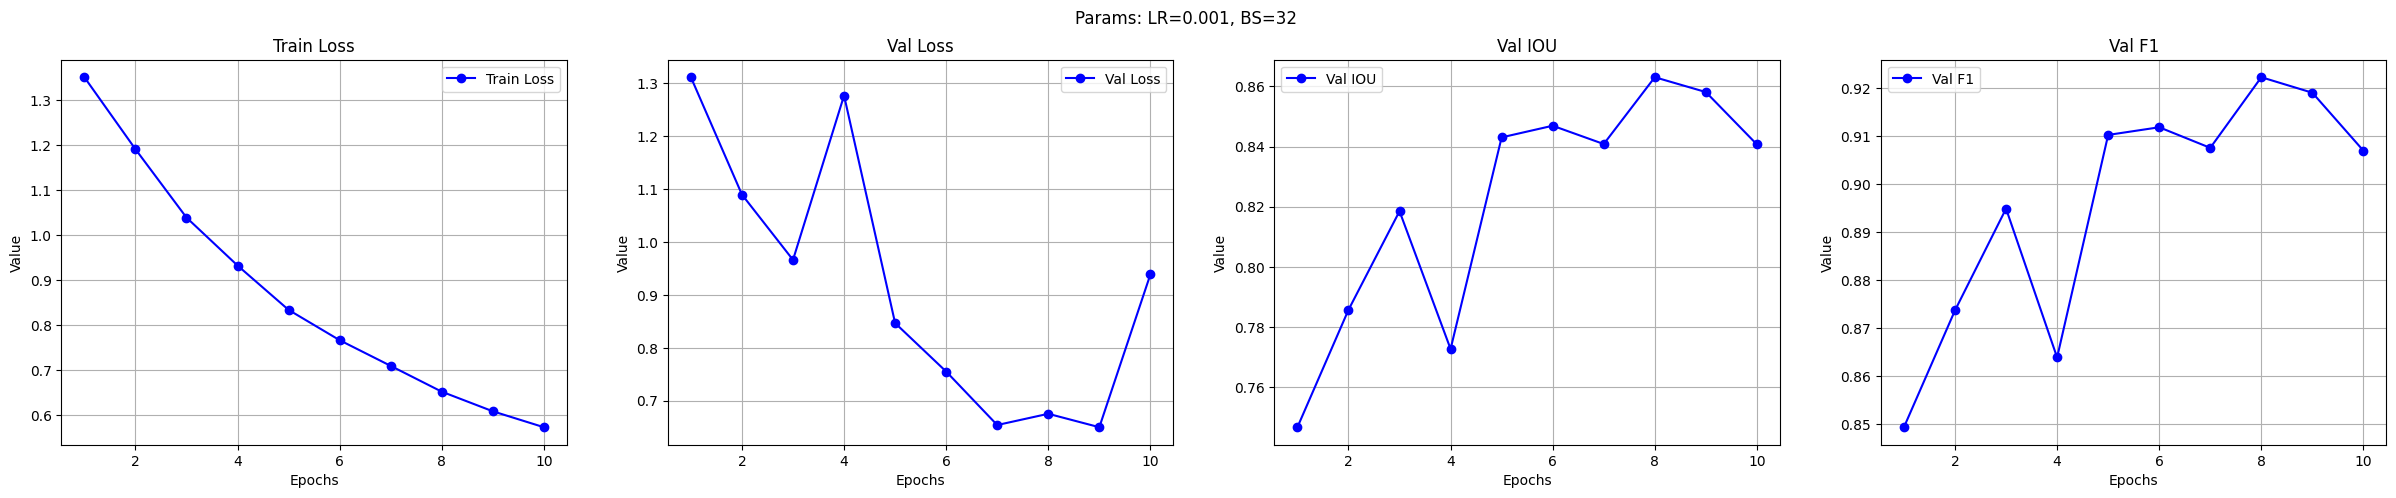

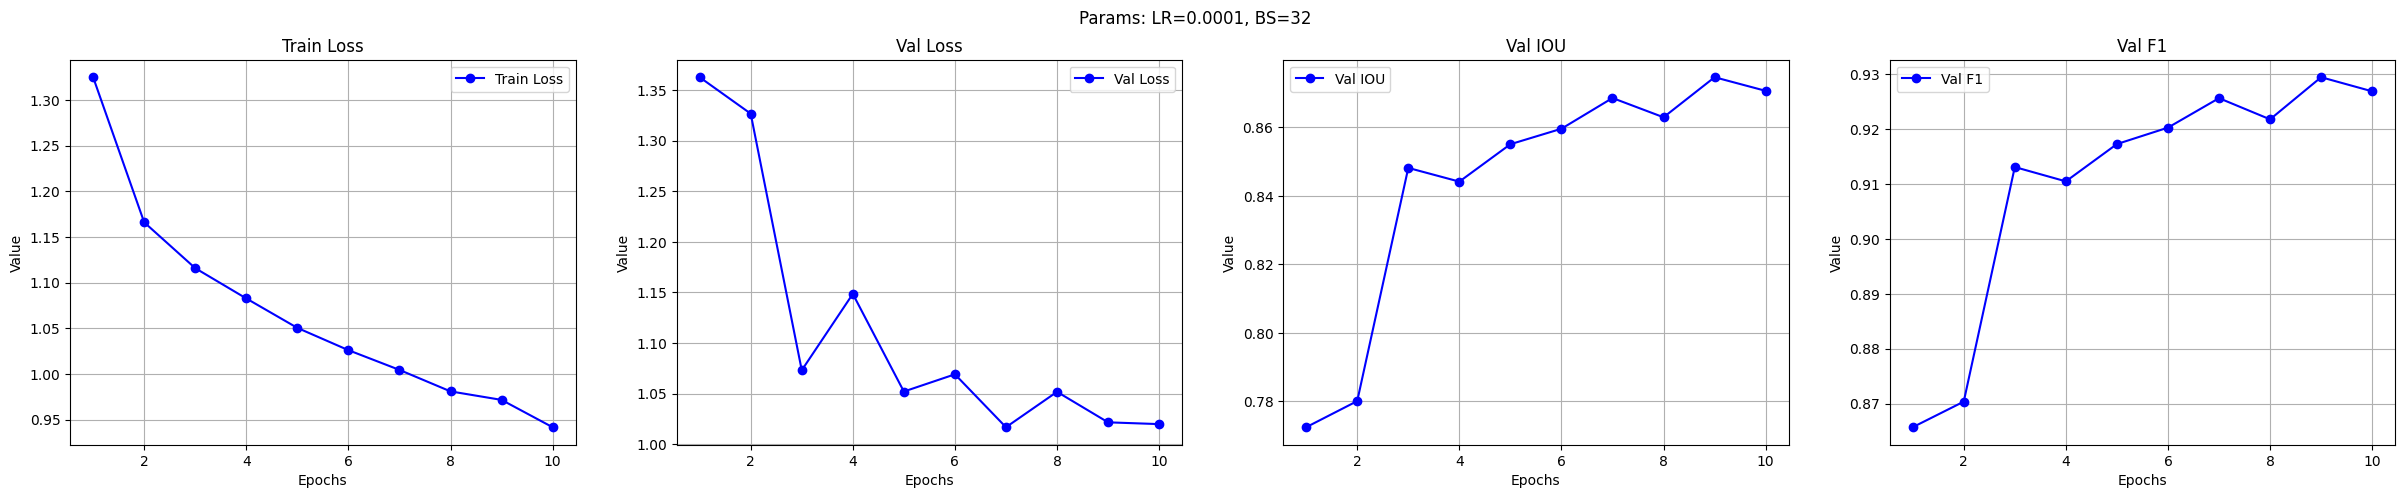

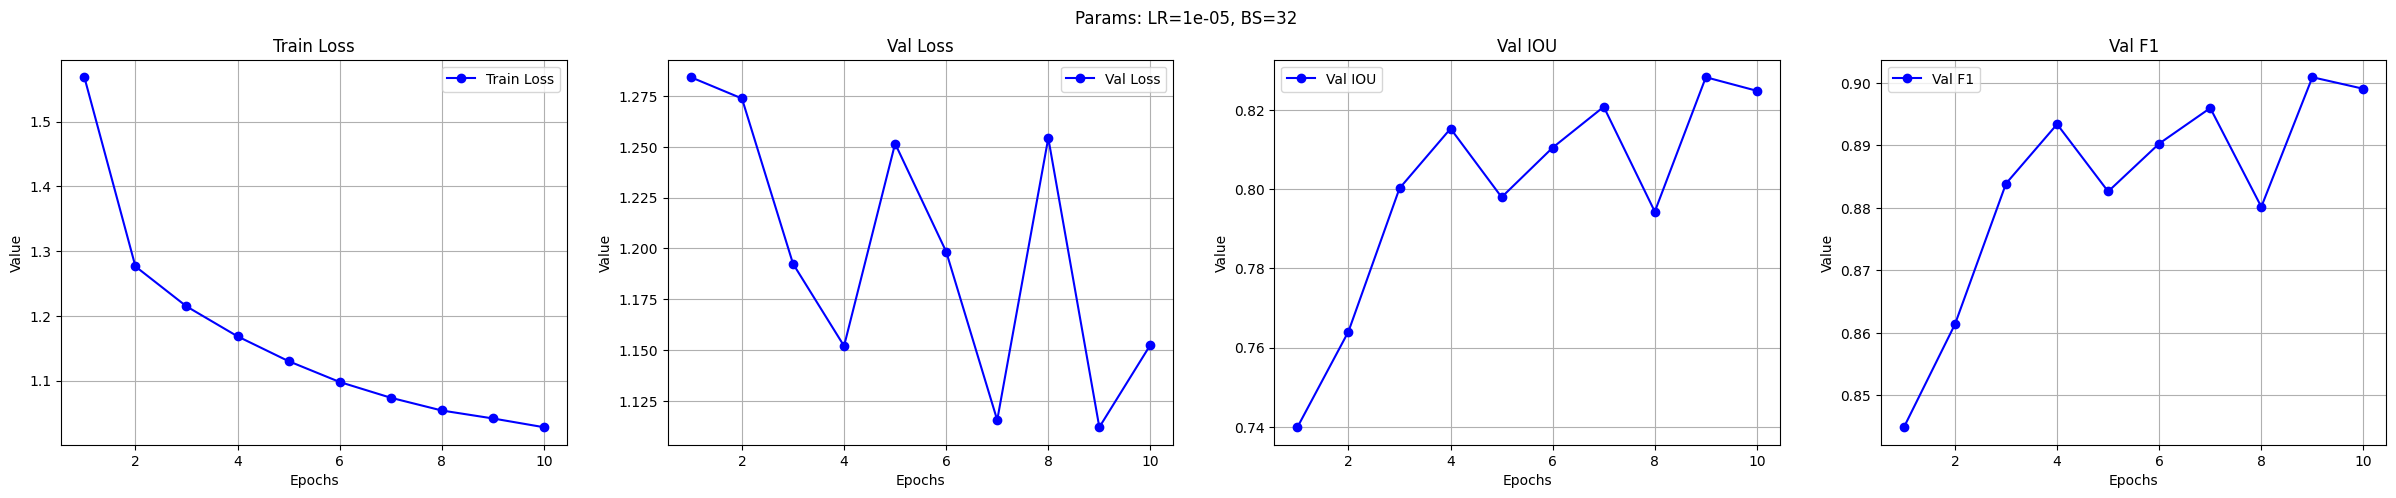

In [ ]:
for params in grid_unet:
    metrics = train_and_evaluate_params(params)
    plot_params(params, metrics)

Наилучший результат:
- TrainLoss и Val Loss: LR=1e-3, BS=8
- Val IOU: LR=1e-4, BS=8
- Val F1: LR=1e-4, BS=8

Выводы:
- при меньшем lr плавнее результаты, тк идет постепенное обновление весов, без резких скачков, хоть на обучение и будет тратиться больше времени
- при больших батчах (32) результаты менее стабильны, особенно на валидационных данных, чем при меньших размерах батчей (8)

# Модификация

Идея: добавление свертки (вместо двух раз - три)


In [15]:
@dataclass
class Config_new:
    image_size = (128, 128)
    batch_size = 16
    epochs = 10
    learning_rate = 0.001
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_split = 0.8

config_new = Config_new()

In [17]:
class EncBlock_new(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncBlock_new, self).__init__()

        self.encblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            )

    def forward(self, x):
        return self.encblock(x)

class UNet_new(UNet):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = EncBlock_new(in_channels, 64)
        self.enc2 = EncBlock_new(64, 128)
        self.enc3 = EncBlock_new(128,256)
        self.enc4 = EncBlock_new(256,512)
        # bottleneck
        self.bottleneck = EncBlock_new(512, 1024)

In [25]:
class Trainer_new(Trainer):
  def __init__(self, config_new):
    super().__init__(config_new)
    self.config = config_new
    self.model = UNet_new().to(config_new.device)

In [26]:
trainer_new = Trainer_new(config_new)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [27]:
trainer_new.run()

100%|██████████| 46/46 [00:12<00:00,  3.59it/s]


Epoch 1 / 10, Train Loss: 1.9252, Val Loss: 1.9586, Val IoU: 0.4274, Val F1-score: 0.5912


100%|██████████| 46/46 [00:12<00:00,  3.68it/s]


Epoch 2 / 10, Train Loss: 1.9254, Val Loss: 1.9795, Val IoU: 0.4253, Val F1-score: 0.5890


100%|██████████| 46/46 [00:12<00:00,  3.67it/s]


Epoch 3 / 10, Train Loss: 1.9249, Val Loss: 1.9745, Val IoU: 0.4248, Val F1-score: 0.5884


100%|██████████| 46/46 [00:12<00:00,  3.65it/s]


Epoch 4 / 10, Train Loss: 1.9243, Val Loss: 2.0070, Val IoU: 0.4196, Val F1-score: 0.5834


100%|██████████| 46/46 [00:12<00:00,  3.60it/s]


Epoch 5 / 10, Train Loss: 1.9250, Val Loss: 1.9891, Val IoU: 0.4225, Val F1-score: 0.5861


100%|██████████| 46/46 [00:12<00:00,  3.67it/s]


Epoch 6 / 10, Train Loss: 1.9266, Val Loss: 2.0039, Val IoU: 0.4243, Val F1-score: 0.5878


100%|██████████| 46/46 [00:12<00:00,  3.65it/s]


Epoch 7 / 10, Train Loss: 1.9249, Val Loss: 1.9635, Val IoU: 0.4246, Val F1-score: 0.5881


100%|██████████| 46/46 [00:12<00:00,  3.58it/s]


Epoch 8 / 10, Train Loss: 1.9254, Val Loss: 1.9321, Val IoU: 0.4330, Val F1-score: 0.5967


100%|██████████| 46/46 [00:12<00:00,  3.65it/s]


Epoch 9 / 10, Train Loss: 1.9242, Val Loss: 1.9782, Val IoU: 0.4238, Val F1-score: 0.5874


100%|██████████| 46/46 [00:14<00:00,  3.25it/s]


Epoch 10 / 10, Train Loss: 1.9255, Val Loss: 1.9434, Val IoU: 0.4290, Val F1-score: 0.5926
Testing...


100%|██████████| 230/230 [01:13<00:00,  3.11it/s]

Test Loss: 2.0083, Test IoU: 0.4153, Test F1-score: 0.5784


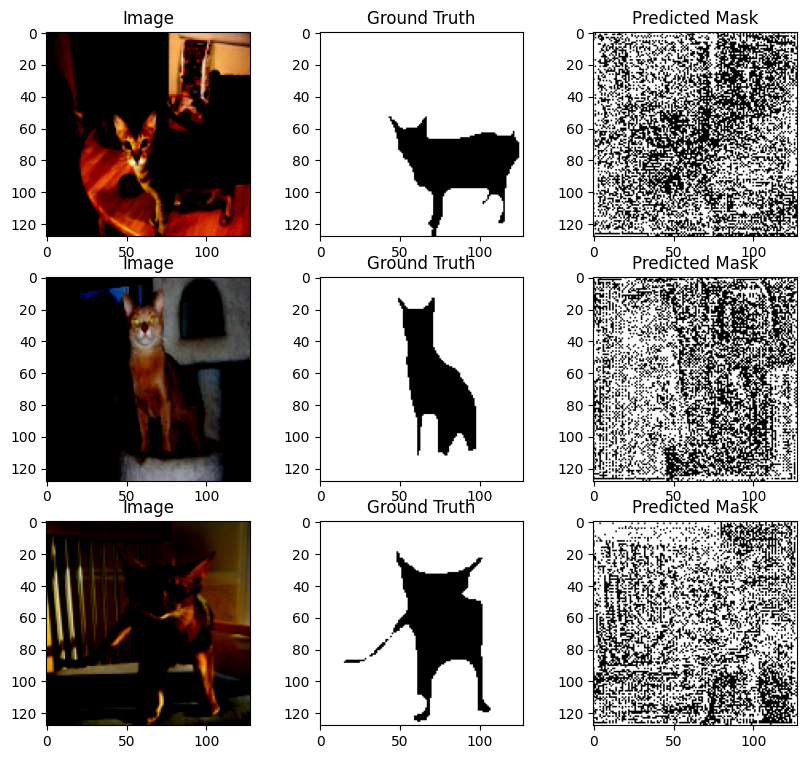

In [28]:
trainer_new.inference_and_plot_samples(n_samples=3)

In [29]:
train_losses_new = trainer_new.train_losses
val_losses_new = trainer_new.val_losses
val_ious_new = trainer_new.val_ious
val_f1s_new = trainer_new.val_f1s

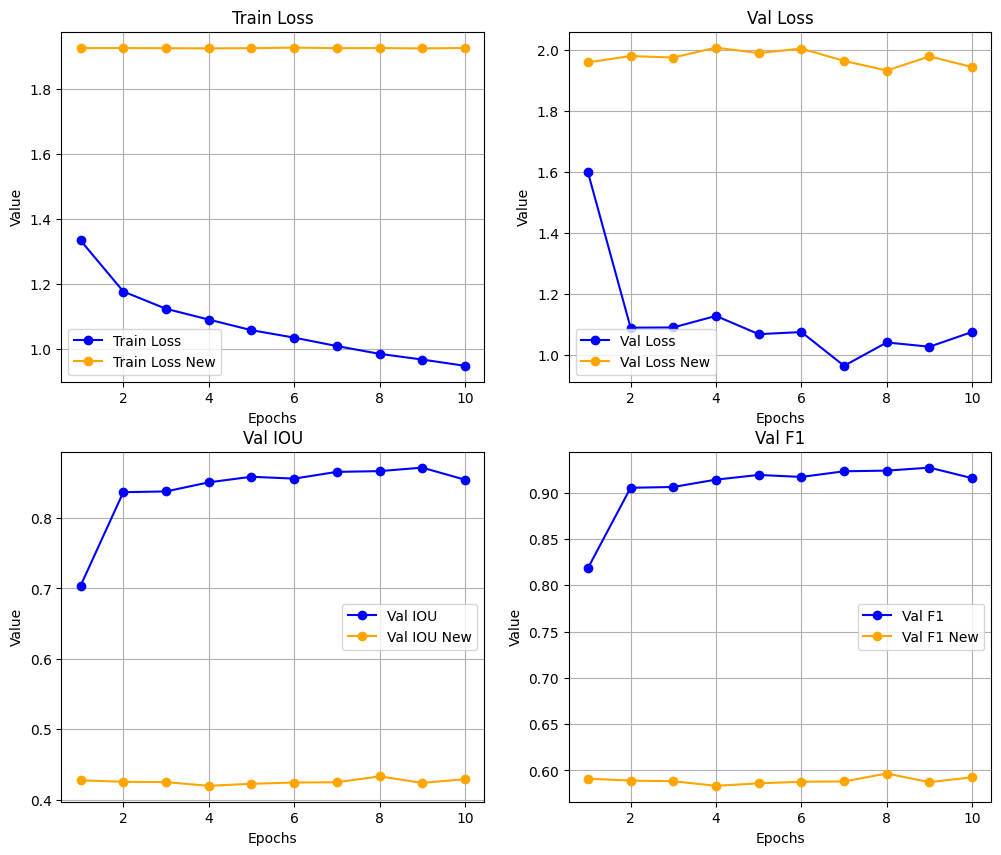

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(range(1, len(train_losses_new) + 1), train_losses[:10], label='Train Loss', color='blue', marker='o')
axs[0, 0].plot(range(1, len(train_losses_new) + 1), train_losses_new, label='Train Loss New', color='orange', marker='o')
axs[0, 0].set_title('Train Loss')

axs[0, 1].plot(range(1, len(val_losses_new) + 1), val_losses[:10], label='Val Loss', color='blue', marker='o')
axs[0, 1].plot(range(1, len(val_losses_new) + 1), val_losses_new, label='Val Loss New', color='orange', marker='o')
axs[0, 1].set_title('Val Loss')

axs[1, 0].plot(range(1, len(val_ious_new) + 1), val_ious[:10], label='Val IOU', color='blue', marker='o')
axs[1, 0].plot(range(1, len(val_ious_new) + 1), val_ious_new, label='Val IOU New', color='orange', marker='o')
axs[1, 0].set_title('Val IOU')

axs[1, 1].plot(range(1, len(val_f1s_new) + 1), val_f1s[:10], label='Val F1', color='blue', marker='o')
axs[1, 1].plot(range(1, len(val_f1s_new) + 1), val_f1s_new, label='Val F1 New', color='orange', marker='o')
axs[1, 1].set_title('Val F1')


for i in range(2):
  for j in range(2):
    axs[i, j].set_xlabel('Epochs')
    axs[i, j].set_ylabel('Value')
    axs[i, j].legend()
    axs[i, j].grid()

Итог:
- предсказание некорректно так как значение IOU < 0.5 ("В COCO и других стандартах IoU ≥ 0.5 используется как порог для классификации предсказаний")
- на Predicted Mask видны очертания фона, особенно если резкие границы (на стенах) - но инфы о нет в Ground Truth
- модель не улучшает свои значения в течение всего обучения

Возможные причины:
- снижение разрешения при дополнительных свёртках -> потеря мелких деталей, нужных для сегментации, так как сразу использовано несколько свероток - взяты более глубокие признаки и пропущены более явные
- обучение с epoches = 10 - возможно маленькое колво эпох для усложненной модели